In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import re
import json
import collections


from util import get_data
from util import mapping
from util import clean_data
from util import config
from util import plot_clusters
from util import process_data

import sklearn.cluster
import sklearn.neighbors
import scipy

In [268]:
RTE_IDS = pd.read_feather(config.PROCESSED_DATA_PATH + 'deduped_rte_ids.feather')
trips_unscaled = process_data.get_features_from_rte_files(RTE_IDS.rte_id.values)
trips_unscaled = pd.read_feather(config.PROCESSED_DATA_PATH + 'trips_unscaled.feather')
trips_unscaled.describe()

0
1000
2000
3000
4000
5000


,rte_id,dist,avg_slope_climbing,avg_slope_descending,max_slope,dist_climbing,dist_downhill,dist_6percent,dist_9percent,dist_12percent
count,4.871000e+03,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000
mean,3.166562e+07,35.904408,3.970781,-1.167413,12.541906,0.141471,0.090769,0.047210,0.016156,0.005258
std,1.697550e+07,20.284349,1.376976,0.880347,4.727895,0.079782,0.064960,0.046103,0.024209,0.011555
min,1.575248e+06,1.403826,0.000000,-9.636679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.679946e+07,21.310344,3.015837,-1.484022,9.239320,0.082690,0.042526,0.013998,0.000480,0.000000
50%,3.438847e+07,31.796990,3.748798,-0.970051,12.210086,0.131899,0.079627,0.034416,0.007084,0.000207
75%,4.816913e+07,46.229336,4.696955,-0.601602,15.685277,0.191754,0.126949,0.066330,0.021327,0.005267
max,5.651015e+07,122.442250,9.957725,0.330684,24.984074,0.689942,0.554247,0.446546,0.216830,0.128748


In [ ]:
feature_importance_dict = {'dist': 1.,
                      'avg_slope_climbing': 0.2,
                      'avg_slope_descending': 0.01,
                      'max_slope': 0.2,
                      'dist_climbing': 0.3,
                      'dist_downhill': 0.01,
                      'dist_6percent': 0.2,
                      'dist_9percent': 0.2,
                      'dist_12percent': 0.1,
                      'avg_speed': 0.}

In [343]:
trips_unscaled.describe()

,rte_id,dist,avg_slope_climbing,avg_slope_descending,max_slope,dist_climbing,dist_downhill,dist_6percent,dist_9percent,dist_12percent
count,4.871000e+03,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000
mean,3.166562e+07,35.904408,3.970781,-1.167413,12.541906,0.141471,0.090769,0.047210,0.016156,0.005258
std,1.697550e+07,20.284349,1.376976,0.880347,4.727895,0.079782,0.064960,0.046103,0.024209,0.011555
min,1.575248e+06,1.403826,0.000000,-9.636679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.679946e+07,21.310344,3.015837,-1.484022,9.239320,0.082690,0.042526,0.013998,0.000480,0.000000
50%,3.438847e+07,31.796990,3.748798,-0.970051,12.210086,0.131899,0.079627,0.034416,0.007084,0.000207
75%,4.816913e+07,46.229336,4.696955,-0.601602,15.685277,0.191754,0.126949,0.066330,0.021327,0.005267
max,5.651015e+07,122.442250,9.957725,0.330684,24.984074,0.689942,0.554247,0.446546,0.216830,0.128748


In [344]:
trips_eng = process_data.engineer_features(trips_unscaled)

trips_eng.set_index('rte_id', inplace=True)
pop_detour = pd.read_feather(config.PROCESSED_DATA_PATH + 'rte_pop_detour.feather')

trips_all = pd.merge(trips_eng, pop_detour, on='rte_id')

trips_scaled = process_data.scale_dataset(trips_all)
trips_all.describe()

,rte_id,dist,avg_slope_climbing,avg_slope_descending,max_slope,dist_climbing,dist_downhill,dist_6percent,dist_9percent,dist_12percent,detour_score,popularity
count,4.871000e+03,4.871000e+03,4.871000e+03,4.871000e+03,4.871000e+03,4.871000e+03,4.871000e+03,4.871000e+03,4.871000e+03,4.871000e+03,4.871000e+03,4.871000e+03
mean,3.166562e+07,-4.726254e-16,-6.841399e-16,-2.071383e-16,-2.990377e-17,1.166976e-16,-1.429546e-16,6.710114e-17,4.576735e-16,-3.697856e-16,2.508999e-16,3.500929e-16
std,1.697550e+07,1.000103e+00,1.000103e+00,1.000103e+00,1.000103e+00,1.000103e+00,1.000103e+00,1.000103e+00,1.000103e+00,1.000103e+00,1.000103e+00,1.000103e+00
min,1.575248e+06,-5.135700e+00,-2.883993e+00,-9.621358e+00,-2.653019e+00,-1.773386e+00,-1.397458e+00,-1.814207e+00,-1.030798e+00,-6.374766e-01,-4.108109e+00,-1.879065e+00
25%,1.679946e+07,-5.973199e-01,-6.935792e-01,-3.596789e-01,-6.986038e-01,-7.368308e-01,-7.427356e-01,-7.148312e-01,-9.611148e-01,-6.374766e-01,-4.062552e-01,-7.603765e-01
50%,3.438847e+07,7.039051e-02,-1.612270e-01,2.242096e-01,-7.019065e-02,-1.199887e-01,-1.715456e-01,5.831784e-02,-2.354567e-01,-5.917218e-01,1.448026e-01,-7.686304e-03
75%,4.816913e+07,6.948252e-01,5.274233e-01,6.427784e-01,6.649246e-01,6.303170e-01,5.570127e-01,7.383434e-01,6.649823e-01,3.067363e-01,6.200186e-01,6.235850e-01
max,5.651015e+07,2.320013e+00,4.348340e+00,1.701886e+00,2.631921e+00,6.875296e+00,7.135562e+00,2.984624e+00,3.604932e+00,5.231462e+00,2.795985e+00,4.950016e+00


In [341]:
    feature_sc = pd.read_feather(config.MODEL_PATH + 'feature_importance.feather')
    feature_scaling = dict()
    for i, row in feature_sc.iterrows():
        feature_scaling[row.feature_names] = abs(row.scaling)
    # Other features
    feature_scaling['popularity'] = 0.5
    feature_scaling['detour_score'] = 0.5
    feature_scaling

{'dist': 1.4547590032536812,
 'avg_slope_climbing': 0.2689761427704118,
 'avg_slope_descending': 0.6183348622895223,
 'max_slope': 0.5163237945391957,
 'dist_climbing': 0.11458979915479701,
 'dist_downhill': 0.4668832578561276,
 'dist_6percent': 0.2782635437163466,
 'dist_9percent': 0.23337194078758589,
 'dist_12percent': 0.35743408028696005,
 'popularity': 0.5,
 'detour_score': 0.5}

In [ ]:
pts_per_degree = 500
gp, gd = clean_data.make_road_backbone(trips_scaled.rte_id.tolist(), 
    'grid_points_{}'.format(pts_per_degree),
    'rtes_at_grid_{}'.format(pts_per_degree),
     pts_per_degree)
gridpts_at_rte = clean_data.find_gridpts_at_rte(
    gd, 'gridpts_at_rte', pts_per_degree)

## Features

In [12]:
RTE_IDS = pd.read_feather(config.PROCESSED_DATA_PATH + 'deduped_rte_ids.feather')

trip_data = []
for i, rte_id in enumerate(rides.index.tolist()):
#     if rte_id == 23586828: continue
    if not i % 200: print(i)
    a = pd.read_feather(config.CLEAN_TRIPS_PATH + '{}.feather'.format(rte_id))
    if a.dist.sum() < 1:
        continue
    if 5 * mapping.dist_lat_lon(a.lat.min(), a.lon.min(), a.lat.max(), a.lon.max()) < a.dist.sum():
        print('{}: whirly!'.format(rte_id))
        continue
        
    max_slope = a.slope.max()
    avg_slope_climbing = a[a.slope > 3].slope.mean()
    avg_slope_descending = a[a.slope < -3].slope.mean()
    dist_climbing = a[a.slope > 3].dist.sum() / a.dist.sum()
    dist_downhill = a[a.slope < -3].dist.sum() / a.dist.sum()
    dist_6percent = a[a.slope > 6].dist.sum() / a.dist.sum()
    dist_9percent = a[a.slope > 9].dist.sum() / a.dist.sum()
    dist_12percent = a[a.slope > 12].dist.sum() / a.dist.sum()
    
    avg_speed = a[a.speed > 2].speed.mean()
    a['dt'] = a.time.diff()
    a.at[0, 'dt'] = 0
    stopped_time = a[a.speed < 2].dt.sum() / a.time.max()
    
    dist = a.dist.sum()
    
    trip_data += [{'rte_id': rte_id, 'dist': dist, 'avg_slope_climbing': avg_slope_climbing, 'avg_slope_descending': avg_slope_descending,
                  'max_slope': max_slope, 'dist_climbing': dist_climbing, 'dist_downhill': dist_downhill,
                  'dist_6percent': dist_6percent, 'dist_9percent': dist_9percent, 'dist_12percent': dist_12percent,
                  }]

        
trips = pd.DataFrame(trip_data)
    

0
51930409: whirly!
200
52253313: whirly!
400
600
16051002: whirly!
16821193: whirly!
800
7981901: whirly!
1000
16280054: whirly!
1200
1400
50777310: whirly!
40206281: whirly!
1600
55221214: whirly!
36428533: whirly!
27562020: whirly!
1800
1794317: whirly!
54992371: whirly!
48606848: whirly!
26013645: whirly!
2000
14923823: whirly!
41000987: whirly!
56494121: whirly!
24871090: whirly!
49086499: whirly!
23937030: whirly!
2200
38379541: whirly!
10625246: whirly!
9293836: whirly!
51370361: whirly!
45905937: whirly!
19857592: whirly!
2400
2888016: whirly!
16275519: whirly!
47921235: whirly!
54607998: whirly!
21557782: whirly!
1601726: whirly!
2652784: whirly!
48142613: whirly!
37689349: whirly!
2600
21573720: whirly!
32147571: whirly!
14705363: whirly!
2296326: whirly!
22796710: whirly!
2800
38705557: whirly!
6015008: whirly!
51757129: whirly!
21332849: whirly!
17363130: whirly!
3000
54091801: whirly!
3200
55829156: whirly!
16461869: whirly!
3400
31047753: whirly!
3600
21221071: whirly!
17

(-20.0, 20.0)

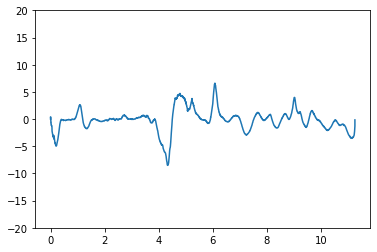

In [4]:
# mapping.dist_lat_lon(a.lat.min(), a.lon.min(), a.lat.max(), a.lon.max())
rte_id = 25521089
a = pd.read_feather(config.CLEAN_TRIPS_PATH + '{}.feather'.format(rte_id))
# plt.plot(a.lon, a.lat, 'k.')
plt.plot(np.cumsum(a.dist), a.slope)
plt.ylim([-20, 20])

In [12]:
t2 = trips[(-10 < trips.avg_slope_descending) & (trips.avg_slope_climbing < 10)]
t2 = t2.drop(t2.index[t2.max_slope > 25])
t2 = t2[(2 < t2.avg_speed) & (t2.avg_speed < 30)]
t2.drop('stopped_time', axis=1, inplace=True)
t2.describe()

,rte_id,dist,avg_slope_climbing,avg_slope_descending,max_slope,dist_climbing,dist_downhill,dist_6percent,dist_9percent,dist_12percent,avg_speed
count,4.318000e+03,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000
mean,3.229137e+07,36.896224,5.835284,-4.806922,12.763707,0.145617,0.093699,0.048044,0.015763,0.004752,16.481179
std,1.672374e+07,20.426265,1.258888,1.067282,4.426172,0.075791,0.061462,0.044103,0.021954,0.009364,4.288793
min,1.575248e+06,1.403826,3.025923,-9.998507,3.058586,0.000819,0.000132,0.000000,0.000000,0.000000,2.672480
25%,1.760175e+07,22.417241,4.913603,-5.311683,9.558836,0.089561,0.047089,0.015968,0.000989,0.000000,13.637808
50%,3.501824e+07,32.596458,5.665248,-4.626587,12.410907,0.135732,0.082991,0.035963,0.007593,0.000441,15.790828
75%,4.854136e+07,47.530738,6.568777,-4.067083,15.717479,0.193865,0.128771,0.067575,0.021601,0.005278,18.933795
max,5.651015e+07,122.442250,9.966429,-3.004356,24.976512,0.689942,0.436783,0.446546,0.184607,0.092317,29.982604


(4318, 11)


(array([ 89., 353., 938., 966., 827., 539., 271., 188., 102.,  45.]),
 array([3.02592339, 3.71997396, 4.41402453, 5.1080751 , 5.80212566,
        6.49617623, 7.1902268 , 7.88427737, 8.57832794, 9.2723785 ,
        9.96642907]),
 <BarContainer object of 10 artists>)

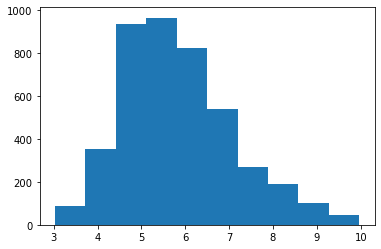

In [15]:
print(t2.shape)
plt.hist(t2.avg_slope_climbing)

In [255]:
# t2.reset_index(drop=True).to_feather(config.PROCESSED_DATA_PATH + 'trips_culled.feather')
t2 = pd.read_feather(config.PROCESSED_DATA_PATH + 'trips_culled.feather')

In [9]:
t3 = process_data.scale_dataset(t2.set_index('rte_id'), [1] * (len(t2.columns) - 1))
t3.reset_index().to_feather(config.PROCESSED_DATA_PATH + 'trips_culled_scaled.feather')
t3

,dist,avg_slope_climbing,avg_slope_descending,max_slope,dist_climbing,dist_downhill,dist_6percent,dist_9percent,dist_12percent,avg_speed
rte_id,,,,,,,,,,
7118848,0.524090,-0.460051,-2.867587,0.163876,-0.863755,-1.020592,-0.633894,-0.446601,-0.267061,-0.623616
23586828,1.744223,-0.402260,-0.068302,-0.097750,-1.001693,-1.031055,-0.652256,-0.611411,-0.483515,0.664834
53915665,0.627491,-0.765641,0.774282,-0.436606,-0.821842,-1.329008,-0.715217,-0.615601,-0.507606,-0.820313
3653661,0.223492,-1.244531,0.950109,-1.383464,-0.797664,-0.989275,-0.985771,-0.718092,-0.507606,-0.714197
38557910,-0.537511,-0.543142,0.471802,-0.333363,-0.473038,-0.226513,-0.585049,-0.619019,-0.507606,-0.328620
...,...,...,...,...,...,...,...,...,...,...
9749723,-0.248361,-0.322877,1.015203,-0.090523,-0.088767,-0.789423,-0.369468,-0.449641,-0.435576,-0.431247
24932345,1.633963,0.804877,-0.099292,0.301829,0.284506,1.113115,0.856808,0.431476,-0.289201,0.379573
41406477,0.213116,-1.127645,0.717706,-0.963177,-0.804505,-0.903709,-0.919013,-0.718092,-0.507606,-0.343783


In [61]:
sd = pd.read_feather(config.MODEL_PATH + 'feature_scaling.feather')
sd = sd.set_index('index')
sd

,dist,avg_slope_climbing,avg_slope_descending,max_slope,dist_climbing,dist_downhill,dist_6percent,dist_9percent,dist_12percent,avg_speed
index,,,,,,,,,,
mean,36.896224,5.835284,-4.806922,12.763707,0.145617,0.093699,0.048044,0.015763,0.004752,16.481179
std,20.423900,1.258742,1.067158,4.425659,0.075783,0.061455,0.044098,0.021952,0.009363,4.288296
column_importance,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Weirder features!

In [272]:
gridpts_at_rte_500 = pd.read_feather(config.PROCESSED_DATA_PATH + 'gridpts_at_rte_500.feather')
gridpts_at_rte_500.set_index('rte_id', inplace=True)

grid_pts_500 = pd.read_feather(config.MODEL_PATH + 'grid_points_500.feather')
grid_pts_500.set_index('grid_id', inplace=True)

rtes_at_grid_500 = pd.read_feather(config.MODEL_PATH + 'rtes_at_grid_500.feather')
rtes_at_grid_500.set_index('grid_id', inplace=True)

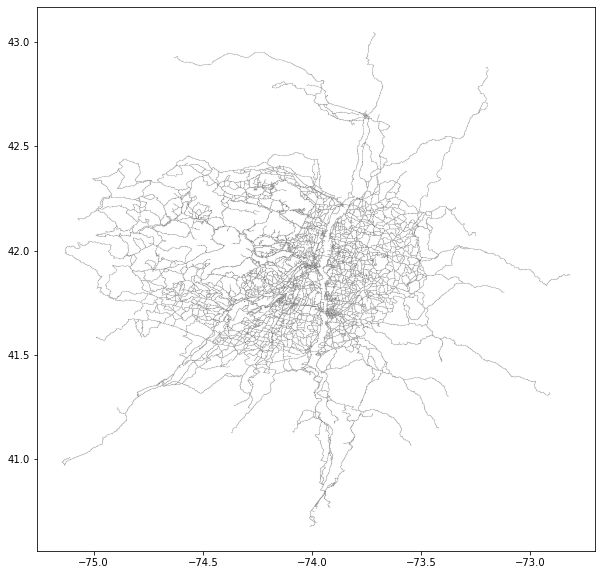

In [274]:
plt.figure(figsize=(10, 10))
plt.plot(grid_pts_500.lon, grid_pts_500.lat, 'k.', markersize=0.05)

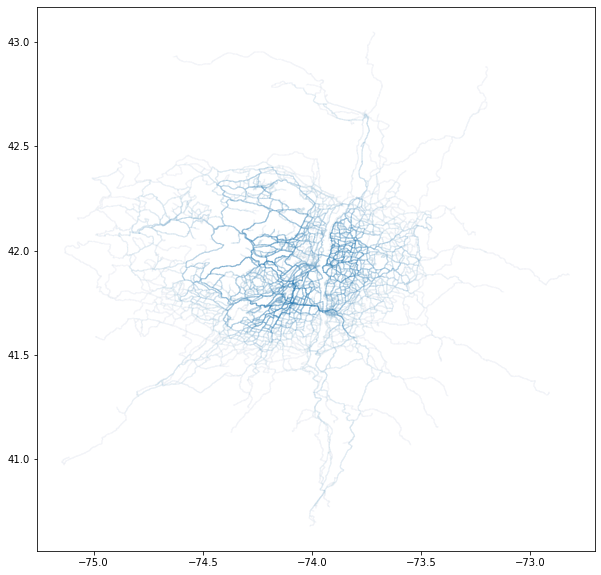

In [283]:
plt.figure(figsize=(10, 10))
grid_popularity
plt.scatter(grid_pts_500.lon, grid_pts_500.lat, grid_popularity/20000)

In [280]:
# Route popularity???
grid_popularity = rtes_at_grid_500.rte_ids.apply(len)
# grid_popularity[[4531792, 4531792]].sum()
rte_popularity = pd.DataFrame({'popularity': 0.}, index=gridpts_at_rte_500.index)
for rte_id, row in gridpts_at_rte_500.iterrows():
    rte_popularity.at[rte_id, 'popularity'] = grid_popularity[row[0].tolist()].mean()
rte_popularity

,popularity
rte_id,
7118848,41.944700
9805313,41.369625
54384283,4.760000
5702199,5.147287
52940048,7.036697
...,...
38476858,2.294118
53673900,5.445596
49303084,4.426966


(array([ 621.,  957., 1248., 1143.,  570.,  229.,   66.,   27.,    7.,
           3.]),
 array([  1.        ,  38.7212766 ,  76.44255319, 114.16382979,
        151.88510638, 189.60638298, 227.32765957, 265.04893617,
        302.77021277, 340.49148936, 378.21276596]),
 <BarContainer object of 10 artists>)

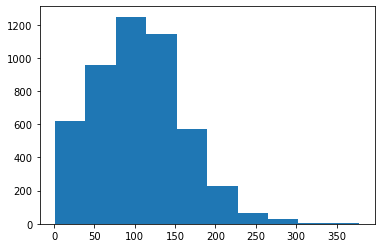

In [285]:
plt.hist(rte_popularity.popularity)

## Detour-worthiness

In [286]:
gridpts_at_rte_500 = pd.read_feather(config.PROCESSED_DATA_PATH + 'gridpts_at_rte_500.feather')
gridpts_at_rte_500.set_index('rte_id', inplace=True)

grid_pts_500 = pd.read_feather(config.MODEL_PATH + 'grid_points_500.feather')
grid_pts_500.set_index('grid_id', inplace=True)

rtes_at_grid_500 = pd.read_feather(config.MODEL_PATH + 'rtes_at_grid_500.feather')
rtes_at_grid_500.set_index('grid_id', inplace=True)

In [288]:
rte_endpts = pd.DataFrame({'lat_start': 0., 'lon_start': 0., 
                           'lat_end': 0., 'lon_end': 0., 'tot_dist': 0},
                          index=gridpts_at_rte_500.index)

for i, rte_id in enumerate(rte_endpts.index.tolist()):
    if not i % 500: print(i)
    a = pd.read_feather(config.CLEAN_TRIPS_PATH + '{}.feather'.format(rte_id))
    rte_endpts.loc[rte_id] = [a.iloc[0].lat, a.iloc[0].lon, 
                              a.iloc[-1].lat, a.iloc[-1].lon, a.dist.sum()]

0
500
1000
1500
2000
2500
3000
3500
4000
4500


In [289]:
grid_detours = collections.defaultdict(list)
grid_detours_prop = collections.defaultdict(list)
deg_to_mile = mapping.degrees_to_miles_ish(1)

n = 0
for rte_id, row in rte_endpts.iterrows():
    if not n % 200: print(n)
    n += 1
    end_to_end = np.linalg.norm(
        np.array([row.lat_start, row.lon_start]) 
        - np.array([row.lat_end, row.lon_end]) 
    ) * deg_to_mile
    for grid_id in gridpts_at_rte_500.loc[rte_id, 'grid_ids']:
        start_to_mid = np.linalg.norm(
            np.array([row.lat_start, row.lon_start]) 
            - np.array([grid_pts_500.at[grid_id, 'lat'],
                        grid_pts_500.at[grid_id, 'lon']])
        ) * deg_to_mile
        end_to_mid = np.linalg.norm(
            np.array([row.lat_end, row.lon_end]) 
            - np.array([grid_pts_500.at[grid_id, 'lat'],
                        grid_pts_500.at[grid_id, 'lon']])
        ) * deg_to_mile
        
        d = start_to_mid + end_to_mid - end_to_end
        grid_detours[grid_id] += [d]
        grid_detours_prop[grid_id] += [d / row.tot_dist]
    
    
gd = pd.DataFrame({'detours': '', 'detours_prop': ''},
                 index=grid_pts_500.index)
n = 0
for k in grid_detours.keys():
    if not n % 1000: print(n)
    n += 1
    gd.at[k, 'detours'] = grid_detours[k]
    gd.at[k, 'detours_prop'] = grid_detours_prop[k]
    
gd.reset_index().to_feather(config.PROCESSED_DATA_PATH + 'detours.feather')

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000


In [290]:
gd.reset_index().to_feather(config.PROCESSED_DATA_PATH + 'detours.feather')

In [299]:
grid_pts_500.head()

,lat,lon,breadcrumb_count,n_routes
grid_id,,,,
1133396,42.293083,-73.988976,351.0,10
1134894,42.290040,-73.986093,21.0,6
1134895,42.291214,-73.987080,156.0,6
1134896,42.292615,-73.987029,95.0,6
1136210,41.920661,-73.985056,2453.0,72


(array([50163.,   918.,  1800.,  4480.,  6794.,  6763.,  3219.,  1548.,
          546.,    68.]),
 array([0.        , 0.05740746, 0.11481492, 0.17222238, 0.22962984,
        0.28703731, 0.34444477, 0.40185223, 0.45925969, 0.51666715,
        0.57407461]),
 <BarContainer object of 10 artists>)

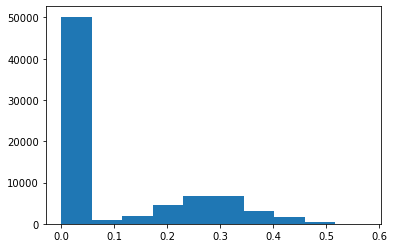

In [307]:
gl = gd.detours_prop.apply(len)
dp = gd.detours_prop.apply(np.mean)
dp[gl < 10] = 0
gd['detour_score'] = dp
plt.hist(dp)

In [308]:
gd.head()

,detours,detours_prop,lon,lat,dp,detour_score
grid_id,,,,,,
1133396,"[0.02634007529677973, 46.055113352601055, 4.66...","[0.0005533607575958149, 0.44516044229293716, 0...",-73.988976,42.293083,0.303796,0.303796
1134894,"[0.061132271439284125, 46.249258275565936, 1.9...","[0.0012842863832409396, 0.4470370121998288, 0....",-73.986093,42.290040,0.000000,0.000000
1134895,"[0.04499483496351786, 46.18790922126588, 2.070...","[0.0009452659372752406, 0.446444023275073, 0.1...",-73.987080,42.291214,0.000000,0.000000
1134896,"[0.09635204002370301, 4.559263918955792, 12.01...","[0.0020241945880062474, 0.2436835747171076, 0....",-73.987029,42.292615,0.000000,0.000000
1136210,"[0.17515669179900328, 2.7467023081079276, 22.2...","[0.003679748010580778, 0.0300361785038455, 0.3...",-73.985056,41.920661,0.196955,0.196955


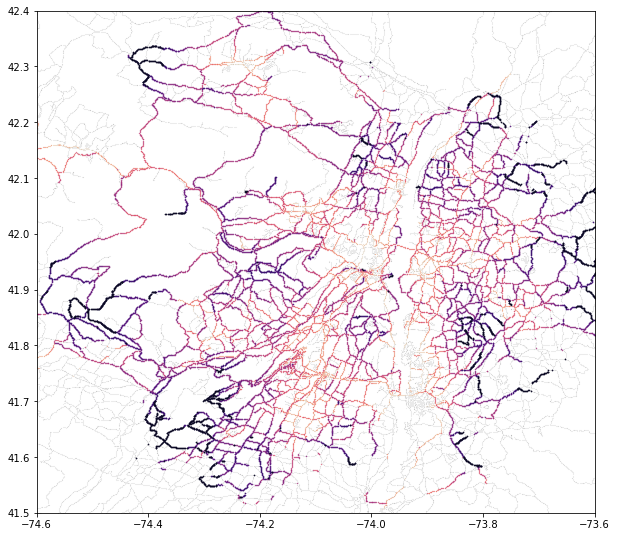

In [305]:
# grid_detours_df = a.detours.apply(np.mean)
plt.figure(figsize=(10, 10))
gd['lon'] = grid_pts_500.lon
gd['lat'] = grid_pts_500.lat
gd['dp'] = dp
plt.plot(grid_pts_500.lon, grid_pts_500.lat, 'k.', markersize=0.05)
# sns.scatterplot(x='lon', y='lat', hue='dp', data=gd, palette='magma_r')


counts = dp[gl > 10]
interval = 0.025
detour_bins = list(np.arange(0.1, 0.4, interval))
colours = sns.color_palette('magma_r', len(detour_bins) + 1)
for i, ll in enumerate(detour_bins):
    b = counts[(ll < counts) & (counts < ll + interval)].index.tolist()
    plt.plot(grid_pts_500.loc[b].lon, grid_pts_500.loc[b].lat, 
             '.', color=colours[i], markersize=0.1 + i * 0.1)
    
b = counts[max(detour_bins) < counts].index.tolist()
plt.plot(grid_pts_500.loc[b].lon, grid_pts_500.loc[b].lat, 
         '.', color=colours[i + 1], markersize=0.1 + (i + 1) * 0.1)
# plt.scatter(, grid_detours_df/50000
plt.xlim([-74.6, -73.6])
plt.ylim([41.5, 42.4])
plt.gca().set_aspect('equal')

In [315]:
gd.loc[row[0].tolist()]

,detours,detours_prop,lon,lat,dp,detour_score
grid_id,,,,,,
1133396,"[0.02634007529677973, 46.055113352601055, 4.66...","[0.0005533607575958149, 0.44516044229293716, 0...",-73.988976,42.293083,0.303796,0.303796
1134894,"[0.061132271439284125, 46.249258275565936, 1.9...","[0.0012842863832409396, 0.4470370121998288, 0....",-73.986093,42.290040,0.000000,0.000000
1134895,"[0.04499483496351786, 46.18790922126588, 2.070...","[0.0009452659372752406, 0.446444023275073, 0.1...",-73.987080,42.291214,0.000000,0.000000
1134896,"[0.09635204002370301, 4.559263918955792, 12.01...","[0.0020241945880062474, 0.2436835747171076, 0....",-73.987029,42.292615,0.000000,0.000000
1136210,"[0.17515669179900328, 2.7467023081079276, 22.2...","[0.003679748010580778, 0.0300361785038455, 0.3...",-73.985056,41.920661,0.196955,0.196955
...,...,...,...,...,...,...
1167605,"[0.11712842296991965, 5.431349179567704, 7.728...","[0.0024606715106301087, 0.059393758469074014, ...",-73.942959,41.710597,0.131083,0.131083
1169105,"[0.04209484268727692, 5.348611294720271, 7.955...","[0.0008843419685727332, 0.05848898991407907, 0...",-73.940916,41.710582,0.128155,0.128155
1170603,"[0.030661465294897994, 0.12465560806385652, 0....","[0.0006441459059404003, 0.0022968167904192805,...",-73.938893,41.706932,0.026720,0.026720


In [346]:
rte_detourscore = pd.DataFrame({'detour_score': 0.}, index=gridpts_at_rte_500.index)
for rte_id, row in gridpts_at_rte_500.iterrows():
    rte_detourscore.at[rte_id, 'detour_score'] = gd.loc[row[0].tolist()].detour_score.mean()
rte_detourscore

a = pd.merge(rte_detourscore.reset_index(), rte_popularity.reset_index(), on='rte_id')
a.head()
a.to_feather(config.PROCESSED_DATA_PATH + 'rte_pop_detour.feather')

(array([ 621.,  957., 1248., 1143.,  570.,  229.,   66.,   27.,    7.,
           3.]),
 array([  1.        ,  38.7212766 ,  76.44255319, 114.16382979,
        151.88510638, 189.60638298, 227.32765957, 265.04893617,
        302.77021277, 340.49148936, 378.21276596]),
 <BarContainer object of 10 artists>)

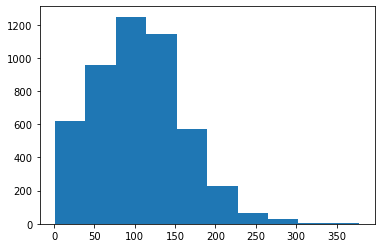

In [348]:
plt.hist(a.popularity)

In [349]:
# rte_detourscore.shape
a.head()

,rte_id,detour_score,popularity
0,7118848,0.183528,41.944700
1,9805313,0.186936,41.369625
2,54384283,0.013122,4.760000
3,5702199,0.016413,5.147287
4,52940048,0.025672,7.036697


In [347]:
a = pd.merge(rte_detourscore.reset_index(), rte_popularity.reset_index(), on='rte_id')
a.head()
a.to_feather(config.PROCESSED_DATA_PATH + 'rte_pop_detour.feather')
a.describe()

,rte_id,detour_score,popularity
count,4.871000e+03,4871.000000,4871.000000
mean,3.166562e+07,0.237428,104.792497
std,1.697550e+07,0.057801,55.241915
min,1.575248e+06,0.000000,1.000000
25%,1.679946e+07,0.213949,62.792155
50%,3.438847e+07,0.245797,104.367934
75%,4.816913e+07,0.273262,139.236993
max,5.651015e+07,0.399022,378.212766


In [156]:
g = gd.reset_index().rename(columns={'rte_id':'grid_id'})
a = pd.merge(grid_pts_1000.reset_index(), g, how='left')

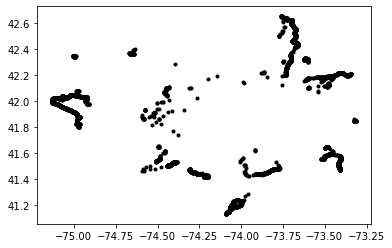

In [179]:
# plt.hist(grid_detours_df * deg_to_mile)
# grid_detours_df *= deg_to_mile
b = grid_detours_df[grid_detours_df > 50].index.tolist()
plt.plot(grid_pts_1000.loc[b].lon, grid_pts_1000.loc[b].lat, 'k.')

In [158]:
a = a[['grid_id', 'detours']].set_index('grid_id')
a.head()

,detours
grid_id,
4531792,"[0.0002832342666483356, 0.03802440718422619, 0..."
4534792,"[0.00034522713215090484, 0.037738684494236, 0...."
4537791,"[0.0006449399715182658, 0.03532126259801212, 0..."
4537792,"[0.0011496644870533368, 0.037439043757251204, ..."
4540789,"[0.0010207805470404674, 0.031833061969014406, ..."


In [149]:
# gd.detours.apply(len).describe()
gd.tail()

,detours
rte_id,
4114154,[0.024537743447703066]
4114167,[0.006911433135355005]
4114168,[0.007948981022860943]
4114169,[0.009227002676353584]
4117154,[0.025109389276403847]


In [144]:
a = grid_detours.keys()
a

dict_keys([4531792, 4534792, 4537791, 4537792, 4540789, 4540790, 4540791, 4543423, 4543424, 4543425, 4543426, 4543427, 4543428, 4543429, 4543430, 4543431, 4543432, 4543787, 4543788, 4543789, 4546421, 4546422, 4546423, 4546432, 4546433, 4546434, 4546725, 4546784, 4546785, 4546786, 4546787, 4549420, 4549421, 4549435, 4549436, 4549437, 4549724, 4549725, 4549726, 4549727, 4549783, 4549784, 4552418, 4552419, 4552438, 4552439, 4552440, 4552441, 4552442, 4552443, 4552444, 4552445, 4552724, 4552728, 4552729, 4552730, 4552731, 4552732, 4552733, 4552734, 4552735, 4552736, 4552782, 4552783, 4555416, 4555417, 4555418, 4555445, 4555446, 4555724, 4555736, 4555737, 4555738, 4555739, 4555780, 4555781, 4555782, 4558415, 4558416, 4558446, 4558447, 4558724, 4558739, 4558740, 4558741, 4558742, 4558779, 4558780, 4561414, 4561415, 4561448, 4561449, 4561724, 4561742, 4561743, 4561777, 4561778, 4561779, 4564413, 4564414, 4564449, 4564450, 4564451, 4564724, 4564743, 4564744, 4564745, 4564746, 4564747, 4564748,

In [145]:
grid_detours[4531792]

[0.0002832342666483356,
 0.03802440718422619,
 0.7639565124668315,
 0.07667357443740792]